# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2024/2025

# Project 2 - Classification in Temporal Data using Sequential Pattern Mining

## Logistics 
**_Read Carefully_**

**Students should work in teams of 3 people**. 

Groups with less than 3 people might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `June, 8th (23:59)`.** 

Students should **upload a `.zip` file** containing a folder with all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the `zip` file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202425_P2.ipynb` as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs.**

**Decisions should be justified and results should be critically discussed.** 

Remember that **your notebook should be as clear and organized as possible**, that is, **only the relevant code and experiments should be presented, not everything you tried and did not work, or is not relevant** (that can be discussed in the text, if relevant)! Tables and figures can be used together with text to summarize results and conclusions, improving understanding, readability and concision. **More does not mean better! The target is quality not quantity!**

_**Project solutions containing only code and outputs without discussions will achieve a maximum grade of 10 out of 20.**_

## Dataset and Tools

Amyotrophic Lateral Sclerosis (ALS) is a devastating neurodegenerative disease causing rapid degeneration of motor neurons and usually leading to death by respiratory failure. Since there is no cure, treatment’s goal is to improve symptoms and prolong survival. Non-invasive Ventilation (NIV) has been shown to extend life expectancy and improve quality of life, thus it is key to effectively predict if ALS patients will be eligible for NIV in the near future based on disease progression. In this context, Martins et al. (2021) proposed to learn prognostic models using disesase progression patterns (https://ieeexplore.ieee.org/document/9426397), and formulated the following prognostic prediction problem (schematized in Figure below): given a specific ALS patient static data collected at diagnosis and temporal data from disease follow-up, can we effectively use these clinical evaluations to predict if this patient will require NIV within k days of last evaluation?

<img src="prognostic_problem.png" alt="Prognostic Prediction" style="width: 500px;"/>

In this project, we will perform a reduced part of the work published by Martins et al. to learn a machine learning model (classifier) able to predict the need for NIV in a time window of 180 days given static and temporal data and sequential patterns as features.

The dataset to be analysed was obtained from the Lisbon ALS database, containing clinical data from ALS patients collected during their follow-up at the hospital. To reduce the preprocessing steps relatively to what was done in the paper and should be done in the real scenario the following **preprocessed datasets** are already provided:

1. `Dataset_Static_Features.csv` - each row is a patient with a REF id described by a set of features collected at diagnosis time. These features are called static since their are not collected over time. Duplicated patients should be deleted.

<img src="static_example.png" alt="Temporal Data" style="width: 1000px;"/>

2. `Dataset_Temporal_Features.csv` - each patient has a set of rows (snapshots), each corresponding to a visit at the hospital and the values collected for a set of temporal features collected over time. The rows per patient REF are sorted in chonologic order, such that the first row and the last row of a REF correspond, respectively to the data collected in the first and last visit at the hospital. In the example below, the patient REF=9 has temporal data describing 5 clinical evaluations (time-points).

<img src="temporal_example.png" alt="Temporal Data" style="width: 500px;"/>

3. `Dataset_NIV_Evolution_180.cvs`- each patient has a set of rows with the true value of NIV (yes or no) 180 days in the future. These are the class labels to be later used to train the classifier. Patient REF=9 does not evolve to need NIV 180 after time-points 1 to 4 but evolves to NIV 180 after time-point 5.

<img src="NIV_evolution_example.png" alt="Temporal Data" style="width: 100px;"/>

In this context, the project has **2 main tasks**:
1. Learn disease progression patterns from the temporal data using temporal pattern mining
2. Learn a classifier to predict NIV using temporal patterns as features together with the static features


**In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org), [`SPMF`](https://www.philippe-fournier-viger.com/software.php) for temporal pattern mining, and [`Scikit-learn`](https://scikit-learn.org/stable/) for classification.**


## Team Identification

**GROUP 07**

Students:

* Daniel Carvalho - 64350
* Gabriel Meirinho - 64873
* Rita Silva - 56798

## 1. Learn disease progression patterns from the temporal data using temporal pattern mining

In this first task you should load and preprocessed the dataset **`Dataset_Temporal_Features.csv`** in order to compute sequential patterns for each patient. 

For that, you first need to load and preprocess this dataset and then transform the temporal data into a **sequence database**.

You should consider **a minimum of 2 time-points** and a **maximum of 5 time-points** per patient.

The sequential pattern mining algorithm `Fourier08` (https://www.philippe-fournier-viger.com/spmf/ClosedSequentialPatterns_TimeConstraints.php), an extension of `PrefixSpan` able to **deal with time** and compute **close patterns**, should be used.

#### Libraries

In [ ]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

In [ ]:
pd.set_option('display.max_colwidth', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### Helper Functions

In [ ]:
def alsfrs_intervals(val):
    if val < 4:
        return '<4'
    elif 4 <= val < 8:
        return '[4,8['
    elif 8 <= val < 12:
        return '[8,12['
    else:
        return '12'
    
def alsfrs_r(val):
    if val < 12:
        return '<12'
    elif 12 <= val < 24:
        return '[12,24['
    elif 24 <= val < 36:
        return '[24,36['
    else:
        return '>=36'

def create_sequence_db_df(df):
    records = []
    item_mapping = {}
    item_counter = 1

    all_features = {
        'ALSFRSb': ['<4', '[4,8[', '[8,12[', '12'],
        'ALSFRSsUL': ['<4', '[4,8[', '[8,12[', '12'],
        'ALSFRSsT': ['<4', '[4,8[', '[8,12[', '12'],
        'ALSFRSsLL': ['<4', '[4,8[', '[8,12[', '12'],
        'R': ['<4', '[4,8[', '[8,12[', '12'],
        'ALSFRS-R': ['<12', '[12,24[', '[24,36[', '>=36']
    }

    for feature, values in all_features.items():
        for value in values:
            key = f"{feature}={value}"
            if key not in item_mapping:
                item_mapping[key] = item_counter
                item_counter += 1

    for ref, group in df.groupby('REF'):
        parts = []
        parts_raw = [] 
        for t, (_, row) in enumerate(group.iterrows()):
            items = []
            for col in df.columns:
                if col == 'REF':
                    continue
                value = str(row[col])
                key = f"{col}={value}"
                items.append(str(item_mapping[key]))
            parts.append(f"<{t}> " + " ".join(items) + " -1")

            raw_items = " ".join(f"{col} = {row[col]}"
                                 for col in df.columns if col != 'REF')
            parts_raw.append(f"({t}, {raw_items} )")

        sequence_str = " ".join(parts) + " -2"
        sequence_raw = " ".join(parts_raw)
        records.append({
            'REF': ref,
            'Sequence': sequence_str,
            'Sequence_raw': sequence_raw
        })

    mapping_str = "@CONVERTED_FROM_TEXT\n"
    for key, number in item_mapping.items():
        mapping_str += f"@ITEM={number}={key}\n"

    return pd.DataFrame(records), mapping_str

def save_sequences_and_map(sequences_df, mapping_str, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(mapping_str)
        for seq in sequences_df['Sequence']:
            f.write(seq.strip() + '\n')

def filter_outputs_by_len(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as fin, \
     open(output_file, 'w', encoding='utf-8') as fout:
        for line in fin:
            tps = re.findall(r'<\s*(\d+)\s*>', line)
            if len(tps) == 1 and tps[0] == '0':
                continue
            fout.write(line)
    print(f"Filtered file written to {output_file}")

def is_subsequence(pat, seq):
    i = 0
    for pset in pat:
        while i < len(seq) and not pset.issubset(seq[i]):
            i += 1
        if i == len(seq): return False
        i += 1
    return True

def parse_sequence(raw):
    out = []
    for content in re.findall(r'\(\s*\d+,\s*(.*?)\s*\)', raw):
        toks = content.split()
        s = set()
        for i in range(0, len(toks), 3):
            feat, _, val = toks[i : i+3]
            s.add(f"{feat}={val}")
        out.append(s)
    return out

def extract_pattern_matches(filtered_file: str,
                            sequences: pd.DataFrame) -> pd.DataFrame:
    records = []
    with open(filtered_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line.startswith('<'):
                continue

            pat_str, sup_str = line.split('#SUP:')
            enc_pattern = pat_str.strip()
            support     = int(sup_str.strip())
            sets = re.findall(r'<(\d+)>\s+(.*?)\s+-1', enc_pattern)
            decoded = " ".join(
                f"({t}, " +
                  ", ".join(f"{feat} = {val}" for feat,val in 
                            (item.split('=',1) for item in items.split())) +
                " )"
                for t,items in sets
            )

            pat_sets = [ set(s.split()) for _,s in sets ]
            hits = [
                row.REF
                for _, row in sequences.iterrows()
                if is_subsequence(pat_sets,
                                  parse_sequence(row.Sequence_raw))
            ]
            records.append({
                'pattern':         enc_pattern,
                'decoded_pattern': decoded,
                'support':         support,
                'REF':             hits
            })
    df = pd.DataFrame(records)
    df = df.sort_values(by='support', ascending=False).reset_index(drop=True)
    total = len(sequences)
    df['support_pct'] = (df['support'] / total * 100).round(2)
    return df

def create_feature_visualization_by_timepoints(df_matches):
    timepoint_counts = df_matches['pattern'].apply(lambda x: x.count('<')).unique()
    timepoint_counts = sorted(timepoint_counts)
    all_features = set()
    for timepoints in timepoint_counts:
        patterns_subset = df_matches[df_matches['pattern'].apply(lambda x: x.count('<')) == timepoints]
        for _, row_data in patterns_subset.iterrows():
            features = re.findall(r'(\w+(?:-\w+)?)\s*=\s*([^,)]+)', row_data['decoded_pattern'])
            for feature, value in features:
                key = f"{feature}={value.strip()}"
                all_features.add(key)
    
    colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    feature_colors = {feature: colors[i % len(colors)] for i, feature in enumerate(sorted(all_features))}
    
    n_timepoints = len(timepoint_counts)
    n_cols = 2
    n_rows = (n_timepoints + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    results = {}
    
    for idx, timepoints in enumerate(timepoint_counts):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        patterns_subset = df_matches[df_matches['pattern'].apply(lambda x: x.count('<')) == timepoints]
        print(f"Analyzing {len(patterns_subset)} patterns with {timepoints} timepoints")
        
        feature_counts = {}
        for _, row_data in patterns_subset.iterrows():
            features = re.findall(r'(\w+(?:-\w+)?)\s*=\s*([^,)]+)', row_data['decoded_pattern'])
            for feature, value in features:
                key = f"{feature}={value.strip()}"
                feature_counts[key] = feature_counts.get(key, 0) + 1
        
        if feature_counts:
            top_5 = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)[:5]
            features, counts = zip(*top_5)
            bar_colors = [feature_colors[feature] for feature in features]
            
            bars = ax.barh(range(len(features)), counts, color=bar_colors, alpha=0.8, edgecolor='black')
            ax.set_yticks(range(len(features)))
            ax.set_yticklabels(features)
            ax.set_xlabel('Frequency', fontweight='bold')
            ax.set_title(f'Top 5 Features - {timepoints} Timepoints\n({len(patterns_subset)} patterns)', 
                        fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            for i, bar in enumerate(bars):
                ax.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
                       f'{int(bar.get_width())}', ha='left', va='center', fontweight='bold')
            
            results[f'{timepoints}_timepoints'] = dict(top_5)
        else:
            ax.text(0.5, 0.5, f'No patterns found\nfor {timepoints} timepoints', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{timepoints} Timepoints', fontweight='bold')
            results[f'{timepoints}_timepoints'] = {}
    
    for idx in range(len(timepoint_counts), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    plt.tight_layout()
    plt.show()
    return results

### 1.1. Load and Preprocess Dataset

- Remove all patients (REFs) with missing values in the temporal features.
- Remove all patients with less than 2 time-points.
- For the patients with more than 5 time-points, keep only the first 5.
- In order to reduce the number of patterns to be generated agregate the values of the temporal features using the following intervals (4 intervals for each feature as in Martins et al): 
  1) Intervals for `ALSFRSb, ALSFRSsUL, ALSFRSsT, ALSFRSsLL, and R: <4 [4,8[ [8,12[ 12`;
  2) Intervals for `ALSFRS-R: <12  [12,24[  [24,36[  >=36`

In [501]:
temporal_df = pd.read_csv('Dataset_Temporal_Features.csv', delimiter=';')

In [502]:
temporal_df.head(3)

REF  ALSFRSb  ALSFRSsUL  ALSFRSsT  ALSFRSsLL     R  ALSFRS-R
0    2     12.0        8.0       6.0        4.0  12.0      42.0
1    2     12.0        8.0       6.0        4.0  12.0      42.0
2    2     12.0        8.0       6.0        3.0  12.0      41.0

In [503]:
print(f"Number of nulls per column\n{temporal_df.isnull().sum()}")

Number of nulls per column
REF            0
ALSFRSb      318
ALSFRSsUL    329
ALSFRSsT     329
ALSFRSsLL    329
R            366
ALSFRS-R     381
dtype: int64


#### Remove all patients with missing values in the temporal features

In [504]:
temporal_df = temporal_df.dropna()
print(f"\nNumber of nulls per column\n{temporal_df.isnull().sum()}")


Number of nulls per column
REF          0
ALSFRSb      0
ALSFRSsUL    0
ALSFRSsT     0
ALSFRSsLL    0
R            0
ALSFRS-R     0
dtype: int64


In [505]:
ref_counts = temporal_df['REF'].value_counts()
print(f"\nReference counts:\n{ref_counts}")


Reference counts:
REF
723     26
269     25
608     24
395     24
981     23
        ..
1162     1
1453     1
110      1
519      1
521      1
Name: count, Length: 957, dtype: int64


#### Remove all patients with less than 2 time-points

In [506]:
temporal_df = temporal_df.groupby('REF').filter(lambda x: len(x) >= 2)

#### For the patients with more than 5 time-points, keep only the first 5

In [507]:
temporal_df = temporal_df.groupby('REF').head(5)
print(f"\nNumber of visits per REF after filtering:\n{temporal_df['REF'].value_counts()}")


Number of visits per REF after filtering:
REF
571     5
920     5
922     5
924     5
1539    5
       ..
1027    2
1034    2
1039    2
1043    2
1878    2
Name: count, Length: 691, dtype: int64


#### Unique values of each temporal feature

In [ ]:
for col in temporal_df.columns:
    if col != 'REF':
        unique_values = temporal_df[col].unique()
        print(f"\nUnique values in column '{col}':\n{unique_values}")


Unique values in column 'ALSFRSb':
[12. 10.  9. 11.  7.  8.  6.  4.  5.  2.  0.  1.  3.]

Unique values in column 'ALSFRSsUL':
[8. 5. 6. 3. 4. 2. 7. 1. 0.]

Unique values in column 'ALSFRSsT':
[6. 4. 2. 8. 7. 3. 5. 1. 0.]

Unique values in column 'ALSFRSsLL':
[4. 3. 8. 5. 1. 0. 6. 7. 2.]

Unique values in column 'R':
[12. 11. 10.  9.  8.]

Unique values in column 'ALSFRS-R':
[42. 41. 36. 37. 38. 32. 46. 45. 44. 31. 27. 39. 35. 30. 33. 47. 43. 40.
 29. 28. 34. 25. 23. 26. 19. 24. 48. 16. 22. 21. 20. 18. 15. 17. 13. 14.
 11. 12.]


#### Intervals for the features 'ALSFRSb', 'ALSFRSsUL', 'ALSFRSsT', 'ALSFRSsLL' and 'R'

In [509]:
cols = ['ALSFRSb', 'ALSFRSsUL', 'ALSFRSsT', 'ALSFRSsLL', 'R']
for col in cols:
    temporal_df[col] = temporal_df[col].apply(alsfrs_intervals)

In [510]:
temporal_df.head(3)

REF ALSFRSb ALSFRSsUL ALSFRSsT ALSFRSsLL   R  ALSFRS-R
0    2      12    [8,12[    [4,8[     [4,8[  12      42.0
1    2      12    [8,12[    [4,8[     [4,8[  12      42.0
2    2      12    [8,12[    [4,8[        <4  12      41.0

#### Intervals for feature 'ALSFRS-R'

In [511]:
temporal_df['ALSFRS-R'] = temporal_df['ALSFRS-R'].apply(alsfrs_r)

In [512]:
temporal_df.head(3)

REF ALSFRSb ALSFRSsUL ALSFRSsT ALSFRSsLL   R ALSFRS-R
0    2      12    [8,12[    [4,8[     [4,8[  12     >=36
1    2      12    [8,12[    [4,8[     [4,8[  12     >=36
2    2      12    [8,12[    [4,8[        <4  12     >=36

#### Unique intervals of each temporal feature

In [ ]:
for col in temporal_df.columns:
    if col != 'REF':
        unique_values = temporal_df[col].unique()
        print(f"\nUnique values in column '{col}':\n{unique_values}")


Unique values in column 'ALSFRSb':
['12' '[8,12[' '[4,8[' '<4']

Unique values in column 'ALSFRSsUL':
['[8,12[' '[4,8[' '<4']

Unique values in column 'ALSFRSsT':
['[4,8[' '<4' '[8,12[']

Unique values in column 'ALSFRSsLL':
['[4,8[' '<4' '[8,12[']

Unique values in column 'R':
['12' '[8,12[']

Unique values in column 'ALSFRS-R':
['>=36' '[24,36[' '[12,24[' '<12']


Our pipeline loads the expected CSV file containing the temporal features. We explored the data and checked for inconsistencies or null values. The cleaning process follows a sequence that tries to preserve data integrity. First, all rows with missing values are removed using dropna(). <br>Patients with fewer than 2 observations are removed as required, while those with more than 5 time-points are truncated to keep only the first 5 observations.<br>
The groupby('REF').filter() operation applies a condition to entire groups, keeping only patient groups that meet the minimum time-point requirement. Finally, we transformed continuous numerical features into categorical intervals.<br>

### 1.2. Compute the Sequence Database

Note that items have now the form `Feature=value` and you should have a sequence database with as many sequences as patients. 

Each sequence encodes the several time-points (maximum 5) of each patient.

See `Fourier08` example (https://www.philippe-fournier-viger.com/spmf/ClosedSequentialPatterns_TimeConstraints.php) to undertand the format received by the algorithm, specially the time information. 

Remember also the end of the example with PrefixSpan (https://www.philippe-fournier-viger.com/spmf/PrefixSpan.php) to understand how to use strings instead of integers to encode items .

In [514]:
sequences, map = create_sequence_db_df(temporal_df)

In [ ]:
print(len(sequences['REF'].unique()))

691


In [516]:
sequences.head()

REF  \
0    2   
1    8   
2    9   
3   10   
4   14   

                                                                                                               Sequence  \
0                        <0> 4 7 10 14 20 24 -1 <1> 4 7 10 14 20 24 -1 <2> 4 7 10 13 20 24 -1 <3> 4 6 10 13 20 24 -1 -2   
1                                                                       <0> 4 6 10 15 20 24 -1 <1> 4 5 9 15 20 24 -1 -2   
2  <0> 4 6 10 13 20 24 -1 <1> 4 5 10 14 20 24 -1 <2> 4 6 9 13 19 23 -1 <3> 4 5 10 13 20 24 -1 <4> 4 5 10 13 19 23 -1 -2   
3                                               <0> 3 7 11 15 20 24 -1 <1> 3 7 10 15 20 24 -1 <2> 3 7 11 15 19 24 -1 -2   
4                                                                       <0> 3 6 10 13 19 23 -1 <1> 3 5 9 13 19 23 -1 -2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Sequence_raw  
0                                                                                          (0, ALSFRSb = 12 ALSFRSsUL = [8,12[ ALSFRSsT = [4,8[ ALSFRSsLL = [4,8[ R = 12 ALSFRS-R = >=36 ) (1, ALSFRSb = 12 ALSFRSsUL = [8,12[ ALSFRSsT = [4,8[ ALSFRSsLL = [4,8[ R = 12 ALSFRS-R = >=36 ) (2, ALSFRSb = 12 ALSFRSsUL = [8,12[ ALSFRSsT = [4,8[ ALSFRSsLL = <4 R = 12 ALSFRS-R = >=36 ) (3, ALSFRSb = 12 ALSFRSsUL = [4,8[ ALSFRSsT = [4,8[ ALSFRSsLL = <4 R = 12 ALSFRS-R = >=36 )  
1                                                                                                                                                                                                                                                                                         (0, ALSFRSb = 12 ALSFRSsUL = [4,8[ ALSFRSsT = [4,8[ ALSFRSsLL = [8,12[ R = 12 ALSFRS-R = >=36 ) (1, ALSFRSb = 12 ALSFRSsUL = <4 ALSFRSsT = <4 ALSFRSsLL = [8,12[ R = 12 ALSFRS-R = >=36 )  
2  (0, ALSFRSb = 12 ALSFRSsUL = [4,8[ ALSFRSsT = [4,8[ ALSFRSsLL = <4 R = 12 ALSFRS-R = >=36 ) (1, ALSFRSb = 12 ALSFRSsUL = <4 ALSFRSsT = [4,8[ ALSFRSsLL = [4,8[ R = 12 ALSFRS-R = >=36 ) (2, ALSFRSb = 12 ALSFRSsUL = [4,8[ ALSFRSsT = <4 ALSFRSsLL = <4 R = [8,12[ ALSFRS-R = [24,36[ ) (3, ALSFRSb = 12 ALSFRSsUL = <4 ALSFRSsT = [4,8[ ALSFRSsLL = <4 R = 12 ALSFRS-R = >=36 ) (4, ALSFRSb = 12 ALSFRSsUL = <4 ALSFRSsT = [4,8[ ALSFRSsLL = <4 R = [8,12[ ALSFRS-R = [24,36[ )  
3                                                                                                                                                              (0, ALSFRSb = [8,12[ ALSFRSsUL = [8,12[ ALSFRSsT = [8,12[ ALSFRSsLL = [8,12[ R = 12 ALSFRS-R = >=36 ) (1, ALSFRSb = [8,12[ ALSFRSsUL = [8,12[ ALSFRSsT = [4,8[ ALSFRSsLL = [8,12[ R = 12 ALSFRS-R = >=36 ) (2, ALSFRSb = [8,12[ ALSFRSsUL = [8,12[ ALSFRSsT = [8,12[ ALSFRSsLL = [8,12[ R = [8,12[ ALSFRS-R = >=36 )  
4                                                                                                                                                                                                                                                                           (0, ALSFRSb = [8,12[ ALSFRSsUL = [4,8[ ALSFRSsT = [4,8[ ALSFRSsLL = <4 R = [8,12[ ALSFRS-R = [24,36[ ) (1, ALSFRSb = [8,12[ ALSFRSsUL = <4 ALSFRSsT = <4 ALSFRSsLL = <4 R = [8,12[ ALSFRS-R = [24,36[ )

In [517]:
save_sequences_and_map(sequences, map, 'sequences.txt')

The preprocessed temporal data is transformed into the sequence database format required SPMG. The core operation create_sequence_db_df(temporal_df) converts each patient's temporal data into a structured sequence format. Each patient becomes a single sequence in the database, where their multiple time-points are encoded as ordered events within that sequence. 
Each sequence uses time-stamped itemsets with special delimiters: indicates the time-point, -1 marks the end of an itemset (all features at one time-point), and -2 marks the end of a complete sequence (one patient's entire timeline). 
We printed the number of unique patients in order to confirm that each patient generated exactly one sequence, and displayed the first few sequences to inspect the format. Finally, save_sequences_and_map() exports both the sequences and the item mapping to a text file.

### 1.3. Compute Sequential Patterns

Use `Fourier08` to compute the closed sequential patterns. Trivial patterns of length 1 should be discarded.

Note that later you need to know what are the sequences (patients) where the patterns occur (the algorithm can output that info).

In [ ]:
os.system("java -jar spmf.jar run Fournier08-Closed+time sequences.txt output.txt 25% 0 5 0 5")

0

#### Remove trivial patterns of length 1

In [519]:
filter_outputs_by_len(input_file='output.txt', output_file='filtered_output.txt')

Filtered file written to filtered_output.txt


#### Extract the patterns from txt file

In [520]:
df_matches = extract_pattern_matches('filtered_output.txt', sequences)

In [521]:
df_matches.head(3)

pattern  \
0                    <0> R=12 -1 <1> R=12 -1   
1  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1   
2           <0> ALSFRS-R=>=36 -1 <1> R=12 -1   

                               decoded_pattern  support  \
0                    (0, R = 12 ) (1, R = 12 )      524   
1  (0, ALSFRS-R = >=36 ) (1, ALSFRS-R = >=36 )      511   
2           (0, ALSFRS-R = >=36 ) (1, R = 12 )      502   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     REF  \
0      [2, 8, 9, 10, 17, 18, 20, 21, 24, 30, 34, 35, 36, 39, 40, 42, 43, 45, 46, 49, 50, 54, 55, 56, 64, 66, 67, 72, 74, 78, 79, 82, 85, 88, 91, 93, 94, 100, 103, 104, 105, 111, 113, 115, 119, 122, 125, 126, 133, 136, 137, 141, 144, 145, 151, 153, 156, 161, 162, 164, 165, 166, 167, 169, 171, 173, 174, 176, 177, 178, 179, 180, 185, 196, 197, 200, 201, 202, 205, 207, 210, 211, 212, 213, 214, 215, 216, 219, 220, 227, 236, 238, 241, 242, 247, 250, 253, 256, 259, 261, ...]   
1      [2, 8, 9, 10, 17, 21, 24, 26, 30, 34, 35, 39, 40, 42, 45, 46, 49, 50, 54, 55, 56, 60, 61, 63, 64, 66, 72, 74, 78, 79, 82, 85, 88, 91, 93, 94, 99, 100, 103, 104, 113, 115, 119, 122, 126, 134, 136, 137, 141, 151, 155, 156, 160, 161, 162, 164, 166, 167, 169, 171, 173, 174, 176, 177, 179, 185, 196, 197, 200, 202, 203, 205, 207, 208, 210, 211, 212, 213, 214, 215, 217, 220, 227, 236, 238, 241, 242, 243, 244, 247, 250, 253, 256, 259, 261, 262, 263, 265, 267, 269, ...]   
2  [2, 8, 9, 10, 17, 21, 24, 30, 34, 35, 39, 40, 42, 45, 46, 49, 50, 54, 55, 56, 64, 66, 67, 72, 74, 78, 79, 82, 85, 88, 91, 93, 94, 100, 103, 104, 105, 113, 115, 119, 122, 126, 134, 136, 137, 141, 144, 145, 151, 153, 156, 161, 162, 164, 165, 166, 167, 169, 171, 173, 174, 176, 177, 178, 179, 180, 185, 196, 197, 200, 202, 205, 207, 210, 211, 212, 213, 214, 215, 220, 227, 236, 238, 241, 242, 247, 250, 253, 256, 259, 261, 262, 263, 265, 267, 269, 271, 273, 277, 278, ...]   

   support_pct  
0        75.83  
1        73.95  
2        72.65

#### Binary Matrix Creation from Sequential Patterns

In [ ]:
df_exploded = df_matches[['pattern', 'REF']].explode('REF')

binary_df = pd.crosstab(df_exploded['REF'], df_exploded['pattern'])

binary_df = binary_df.astype(int)

binary_df = binary_df.reset_index()

print(f"Binary matrix shape: {binary_df.shape}")
print(f"Number of patients: {len(binary_df)}")
print(f"Number of patterns: {len(binary_df.columns) - 1}")

binary_df.head()

Binary matrix shape: (691, 5163)
Number of patients: 691
Number of patterns: 5162


pattern  REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0          2                                          1   
1          8                                          1   
2          9                                          1   
3         10                                          1   
4         14                                          0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                                     1   
1                                                                     0   
2                                                                     1   
3                                                                     1   
4                                                                     0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                          1   
1                                                                                          0   
2                                                                                          0   
3                                                                                          0   
4                                                                                          0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                               0   
1                                                                                                               0   
2                                                                                                               0   
3                                                                                                               0   
4                                                                                                               0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                      0   
1                                                                                                      0   
2                                                                                                      0   
3                                                                                                      0   
4                                                                                                      0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                       1   
1                                                                                       0   
2                                                                                       1   
3                                                                                       0   
4                                                                                       0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 ALSFRS-R=>=36 -1  \
0                                                                                                     1   
1                                                                                                     0   
2                                                                                                     0   
3                                                                                                     0   
4                                                                                                     0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R

We executed the sequential pattern mining using the SPMF framework and transformed the results into binary matrices for further analysis. 
The core operation uses the Fournier08 algorithm with the following parameters: 25% minimum support, gap constraints (0 minimum, 5 maximum) and length constraints (0 minimum, 5 maximum) limit pattern complexity. The "Closed+time" variant finds closed sequential patterns, reducing redundancy in the results. Our choice for the initial value of 25% of minimum support is based on the same value that is used in Martins et al. (2021), which provided a basis for exploration. As we shall see later on, we made another experiment with a lower support (20%) and compared the results at the levels of temporal features and shall comment on which support would be more suitable for the future. 
The resulting binary matrix provides a compressed representation of temporal patterns across the patient population. Each column represents a sequential pattern and each row shows which patterns characterize a specific patient's disease progression.

## 2.  Learn a classifier to predict NIV using temporal patterns as features together with the static features

In this task you should create a training set where the features are 1) the original static features `(Dataset_static_features.cvs`and 2) the sequential patterns computed above. The class labels to be used for each patient are in file `Dataset_NIV_Evolution_180.cvs`.

### 2.1. Load/Preprocess the Dataset

- Remember to delete from `Dataset_static_features.csv` the patients you deleted in step 1.1. You should only have one row per patient, thus remove repetitions.
- Remember to delete from `Dataset_NIV_Evolution_180.cvs` the patients you deleted in step 1.1.
- Note that for each patient the class label you need from `Dataset_NIV_Evolution_180.cvs` is the one corresponding to the last time-point you considered in step 1.1.

In [523]:
evolution_df = pd.read_csv('Dataset_NIV_Evolution_180.csv', delimiter=';')
static_df = pd.read_csv('Dataset_Static_Features.csv', delimiter=';')

#### Aligning DataFrames with Patient IDs

In [ ]:
evolution_df = evolution_df[evolution_df['REF'].isin(sequences['REF'])]
static_df = static_df[static_df['REF'].isin(sequences['REF'])]

print(len(evolution_df[~evolution_df['REF'].isin(sequences['REF'])]))
print(len(static_df[~static_df['REF'].isin(sequences['REF'])]))

0
0


In [526]:
static_df.head(3)

REF Gender  Age at onset (years) Revised El Escorial Criteria  Onset  \
0    2   Male                 54.92                     Probable  Limbs   
1    2   Male                 54.92                     Probable  Limbs   
2    2   Male                 54.92                     Probable  Limbs   

   Diagnostic delay (months)  BMI at 1st visit MND familiar history C9orf72  
0                       5.22              17.9                   No     NaN  
1                       5.22              17.9                   No     NaN  
2                       5.22              17.9                   No     NaN

#### Checking for Missing Values in Static Features DataFrame


In [ ]:
print(f"Number of nulls per column in static_df:\n{static_df.isnull().sum()}")

Number of nulls per column in static_df:
REF                                0
Gender                             0
Age at onset (years)               0
Revised El Escorial Criteria       0
Onset                              0
Diagnostic delay (months)          0
BMI at 1st visit                 305
MND familiar history             140
C9orf72                         1634
dtype: int64


In [528]:
static_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3853 entries, 0 to 4321
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   REF                           3853 non-null   int64  
 1   Gender                        3853 non-null   object 
 2   Age at onset (years)          3853 non-null   float64
 3   Revised El Escorial Criteria  3853 non-null   object 
 4   Onset                         3853 non-null   object 
 5   Diagnostic delay (months)     3853 non-null   float64
 6   BMI at 1st visit              3548 non-null   float64
 7   MND familiar history          3713 non-null   object 
 8   C9orf72                       2219 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 301.0+ KB


#### Removing Rows with Missing BMI Values


In [529]:
static_df = static_df.dropna(subset=['BMI at 1st visit'])

#### Handling Missing Values in Static Features DataFrame


In [530]:
static_df = static_df.fillna('unknown')
print(f"\nNumber of nulls per column in static_df after filling:\n{static_df.isnull().sum()}")


Number of nulls per column in static_df after filling:
REF                             0
Gender                          0
Age at onset (years)            0
Revised El Escorial Criteria    0
Onset                           0
Diagnostic delay (months)       0
BMI at 1st visit                0
MND familiar history            0
C9orf72                         0
dtype: int64


In [531]:
evolution_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3853 entries, 0 to 4321
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   REF        3853 non-null   int64 
 1   Evolution  3853 non-null   object
dtypes: int64(1), object(1)
memory usage: 90.3+ KB


In [532]:
len(static_df), len(evolution_df)

(3548, 3853)

In [533]:
evolution_df.head(3)

REF Evolution
0    2         N
1    2         N
2    2         N

In [534]:
static_df.head(3)

REF Gender  Age at onset (years) Revised El Escorial Criteria  Onset  \
0    2   Male                 54.92                     Probable  Limbs   
1    2   Male                 54.92                     Probable  Limbs   
2    2   Male                 54.92                     Probable  Limbs   

   Diagnostic delay (months)  BMI at 1st visit MND familiar history  C9orf72  
0                       5.22              17.9                   No  unknown  
1                       5.22              17.9                   No  unknown  
2                       5.22              17.9                   No  unknown

In [535]:
binary_df

pattern   REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0           2                                          1   
1           8                                          1   
2           9                                          1   
3          10                                          1   
4          14                                          0   
..        ...                                        ...   
686      1795                                          0   
687      1814                                          1   
688      1818                                          0   
689      1877                                          0   
690      1878                                          0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                                     1   
1                                                                     0   
2                                                                     1   
3                                                                     1   
4                                                                     0   
..                                                                  ...   
686                                                                   0   
687                                                                   0   
688                                                                   0   
689                                                                   0   
690                                                                   0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                          1   
1                                                                                          0   
2                                                                                          0   
3                                                                                          0   
4                                                                                          0   
..                                                                                       ...   
686                                                                                        0   
687                                                                                        0   
688                                                                                        0   
689                                                                                        0   
690                                                                                        0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                               0   
1                                                                                                               0   
2                                                                                                               0   
3                                                                                                               0   
4                                                                                                               0   
..                                                                                                            ...   
686                                                                                                             0   
687                                                                                                             0   
688                                                                                                             0   
689                                                    

#### Selecting Last Timepoint for Each Patient


In [ ]:
evolution_df = evolution_df.groupby('REF').tail(1)
static_df = static_df.groupby('REF').tail(1)

#### Merging Static Data with Binary DataFrame


In [ ]:
binary_df = binary_df.merge(static_df, on='REF', how='inner')

In [538]:
binary_df

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0       2                                          1   
1       8                                          1   
2       9                                          1   
3      10                                          1   
4      14                                          0   
..    ...                                        ...   
623  1794                                          1   
624  1795                                          0   
625  1814                                          1   
626  1818                                          0   
627  1877                                          0   

     <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                                 1   
1                                                                 0   
2                                                                 1   
3                                                                 1   
4                                                                 0   
..                                                              ...   
623                                                               0   
624                                                               0   
625                                                               0   
626                                                               0   
627                                                               0   

     <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                      1   
1                                                                                      0   
2                                                                                      0   
3                                                                                      0   
4                                                                                      0   
..                                                                                   ...   
623                                                                                    0   
624                                                                                    0   
625                                                                                    0   
626                                                                                    0   
627                                                                                    0   

     <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                           0   
1                                                                                                           0   
2                                                                                                           0   
3                                                                                                           0   
4                                                                                                           0   
..                                                                                                        ...   
623                                                                                                         0   
624                                                                                                         0   
625                                                                                                         0   
626                                                                                                         0   
627                                                                                                         0   

     <0> ALSFRS-R=

#### Encoding Categorical Variables using One-Hot Encoding

In [ ]:
binary_df = pd.get_dummies(binary_df, columns=['Gender', 'Revised El Escorial Criteria', 'Onset', 'MND familiar history', 'C9orf72'], dtype=int)

In [540]:
binary_df.head(3)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   
2    9                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   
2                                                               1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   
2                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   
2                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   
2                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   
2                                                                                 1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 ALSFRS-R=>=36 -1  \
0                                                                                               1   
1                                                                                               0   
2                                                                                               0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 R=12 -1  \
0                                                                                      1   
1                                                                                      0   
2                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSsT=[4,8[ -1  \
0                                                                                     1   
1                                                                                     0   
2                                                                                     1   

   ...  Onset_Limbs  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...            1                  0            0              0   
1  ...            1                  0            0              0   
2  ...            1                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   
2                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  
0                             0           0            0                1  
1                             0           0            0                1  
2                             0           1            0                0  


#### Merging Evolution Data with Binary DataFrame

In [ ]:
binary_df = binary_df.merge(evolution_df, on='REF', how='left')

In [542]:
binary_df.head(3)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   
2    9                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   
2                                                               1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   
2                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   
2                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   
2                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   
2                                                                                 1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 ALSFRS-R=>=36 -1  \
0                                                                                               1   
1                                                                                               0   
2                                                                                               0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 R=12 -1  \
0                                                                                      1   
1                                                                                      0   
2                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSsT=[4,8[ -1  \
0                                                                                     1   
1                                                                                     0   
2                                                                                     1   

   ...  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...                  0            0              0   
1  ...                  0            0              0   
2  ...                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   
2                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  \
0                             0           0            0                1   
1                             0           0            0                1   
2                             0           1            0                0   

   Evolution  
0          N  
1          Y  
2 

In [543]:
binary_df['Evolution'] = (binary_df['Evolution'] == 'Y').astype(int)

In [544]:
binary_df.head(3)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   
2    9                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   
2                                                               1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   
2                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   
2                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   
2                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   
2                                                                                 1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 ALSFRS-R=>=36 -1  \
0                                                                                               1   
1                                                                                               0   
2                                                                                               0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 R=12 -1  \
0                                                                                      1   
1                                                                                      0   
2                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSsT=[4,8[ -1  \
0                                                                                     1   
1                                                                                     0   
2                                                                                     1   

   ...  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...                  0            0              0   
1  ...                  0            0              0   
2  ...                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   
2                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  \
0                             0           0            0                1   
1                             0           0            0                1   
2                             0           1            0                0   

   Evolution  
0          0  
1          1  
2 

We loaded the two additional datasets: static patient features and NIV evolution outcomes, filtering both to include only patients that do not have insufficient temporal data or missing values We verified that no patients were accidentally excluded, for confirmation.
For BMI values, complete case deletion is used since it was impossible for us to fill the values and thought that it would be incorrect to adopt a strategy with averaging values, as we are dealing with medical data. However, for other categorical variables like family history or genetic markers, missing values are filled as "unknown" rather than deleted. This is to ensure that we can conserve our sample size as much as possible. 
Then the merging process combines three types of features: sequential patterns (from the binary pattern matrix), static demographic/clinical features, and the target variable. The one-hot encoding step transforms categorical variables into binary indicators. The final step converts the string-based evolution indicator ('Y'/'N') into a binary numeric target (1/0).

### 2.2. Create the Training Set

See Section **3.4 Training Set Creation and Model Learning** of the paper Martins et al (2021). 

Note that in this project the original static features are used thus you only need to compute the distance matrix for the sequencial patterns (which are now features), the static features are used as they are.

**Perform the experiments only for binary matrices**.

In [ ]:
X = binary_df.drop(columns='Evolution')
y = binary_df['Evolution']

In [546]:
X.head(2)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 ALSFRS-R=>=36 -1  \
0                                                                                               1   
1                                                                                               0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 R=12 -1  \
0                                                                                      1   
1                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSsT=[4,8[ -1  \
0                                                                                     1   
1                                                                                     0   

   ...  Onset_Limbs  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...            1                  0            0              0   
1  ...            1                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  
0                             0           0            0                1  
1                             0           0            0                1  

[2 rows x 5185 columns]

In [ ]:
print(f"Number of refs: {len(binary_df)}")

Number of refs: 628


As it is required to perform classification, we created the training dataset by separating features from the target variable, splitting data into features (X) and target (y), that contains the binary NIV evolution outcomes that the model will learn to predict.

#### 2.2.3. Learn the model

See section **4.1 Model Evaluation** of the paper Martins et al (2021).

Use only a `Random-Forest`, default parameters and present the results for **5-fold cross-validation** (mean+-std). 

Note that the problem is difficult so don´t expect high performance.

In [ ]:
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print(f"5‐fold CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

5‐fold CV accuracy: 0.557 ± 0.058


We implement the final machine learning evaluation phase, using Random Forest classification with stratified cross-validation to assess the predictive performance of the combined temporal patterns and static features for NIV outcome prediction.
Our results are just below 55%, without tuning any parameters. This can be viewed in several perspectives. The low number of patients and the support; the feature to sample ratio being too extreme; the discretization, and truncation of data; all of them contribute to a difficulty for the model to generalize. On the other hand, the high number of patterns contributes to noise, which makes us conclude that these results are too be expected and, even with tuning parameters, the complexity of the data may not be captured as well without fundamental changes at the level of the sample size and preprocessing.

### Analysis and Discussion

#### Analyzing Class Distribution and Number of Sequential Patterns

In [568]:
evolution_counts = binary_df['Evolution'].value_counts()
print(f"Total patients: {len(binary_df)}")
print(f"Patients requiring NIV: {evolution_counts[1]} ({evolution_counts[1]/len(binary_df)*100:.1f}%)")
print(f"Patients not requiring NIV: {evolution_counts[0]} ({evolution_counts[0]/len(binary_df)*100:.1f}%)")
print(f"Total sequential patterns discovered: {len([col for col in binary_df.columns if col.startswith('<')])}")

Total patients: 628
Patients requiring NIV: 307 (48.9%)
Patients not requiring NIV: 321 (51.1%)
Total sequential patterns discovered: 5162


#### Characteristics of the Patients

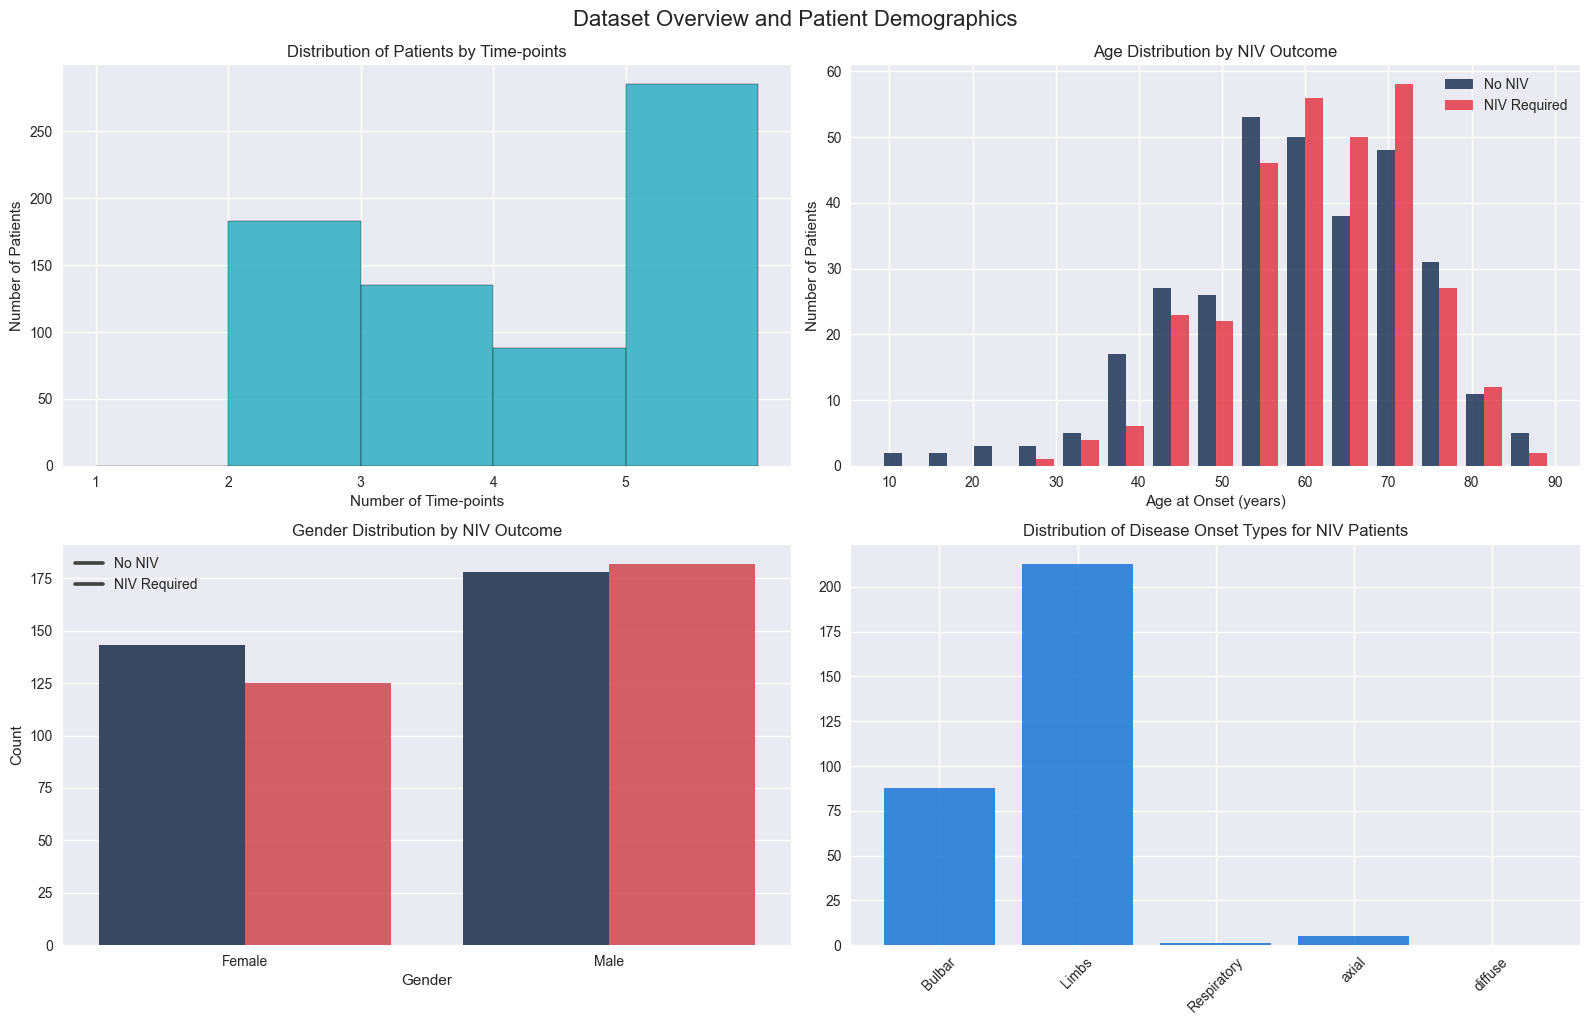

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

ref_counts = temporal_df['REF'].value_counts()
axes[0,0].hist(ref_counts.values, bins=range(1, 7), alpha=0.85, edgecolor='black', color="#30aec2")
axes[0,0].set_xlabel('Number of Time-points')
axes[0,0].set_ylabel('Number of Patients')
axes[0,0].set_title('Distribution of Patients by Time-points')
axes[0,0].set_xticks(range(1, 6))

if 'Age at onset (years)' in binary_df.columns:
    ages_no_niv = binary_df[binary_df['Evolution'] == 0]['Age at onset (years)'].dropna()
    ages_niv = binary_df[binary_df['Evolution'] == 1]['Age at onset (years)'].dropna()
    
    axes[0,1].hist([ages_no_niv, ages_niv], bins=15, alpha=0.85, 
                   label=['No NIV', 'NIV Required'], color=["#1d3557", '#e63946'])
    axes[0,1].set_xlabel('Age at Onset (years)')
    axes[0,1].set_ylabel('Number of Patients')
    axes[0,1].set_title('Age Distribution by NIV Outcome')
    axes[0,1].legend()
else:
    axes[0,1].text(0.5, 0.5, 'Age data not available', ha='center', va='center')
    axes[0,1].set_title('Age Distribution by NIV Outcome')

gender_cols = [col for col in binary_df.columns if 'Gender_' in col]
if gender_cols:
    gender_data = []
    for col in gender_cols:
        gender_name = col.replace('Gender_', '')
        niv_counts = binary_df.groupby('Evolution')[col].sum()
        for outcome in [0, 1]:
            if outcome in niv_counts.index:
                gender_data.append({'Gender': gender_name, 'NIV': outcome, 'Count': niv_counts[outcome]})
    
    if gender_data:
        gender_df = pd.DataFrame(gender_data)
        sns.barplot(data=gender_df, x='Gender', y='Count', hue='NIV', alpha=0.9,
                   palette=['#1d3557', '#e63946'], ax=axes[1,0])
        axes[1,0].set_title('Gender Distribution by NIV Outcome')
        axes[1,0].legend(['No NIV', 'NIV Required'])

onset_cols = [col for col in binary_df.columns if 'Onset_' in col]
if onset_cols:
    niv_patients = binary_df[binary_df['Evolution'] == 1]
    
    onset_data = []
    for col in onset_cols:
        onset_name = col.replace('Onset_', '')
        count = niv_patients[col].sum()
        onset_data.append({'Onset': onset_name, 'Count': count})
    
    if onset_data:
        onset_df = pd.DataFrame(onset_data)
        bars = axes[1,1].bar(onset_df['Onset'], onset_df['Count'], color="#1875D3", alpha=0.85)
        axes[1,1].set_title('Distribution of Disease Onset Types for NIV Patients')
        axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In order to understand the data and analyse how the sequential patterns behave, we strived to answer several questions. The first one, concerning temporal data distribution showed us that the largest group (~280 patients) has the maximum 5 temporal observations. The distribution shows reasonable representation across 2-5 time-points (180-280 patients each), providing sufficient data for temporal pattern mining across all of them. This could possibly lead us to consider that there is good patient retention and consistency in the medical follow-up in the clinical setting of this sample. 
Following this, we wanted to understand the bimodal age distribution: both NIV and non-NIV groups show similar age distributions with peaks around 50-60 and 60-70 years. The substantial overlap between groups suggests age alone is not a strong discriminatory factor for NIV requirement, which could be misleading in the beginning as we were talking about respiratory assistance. There is a significant representation in the 70+ age groups. What can be concluded is that the age similarity between groups suggests that NIV requirement depends more on disease progression patterns, supporting the value of temporal pattern analysis over solely static demographic predictors.
In terms of gender distribution by NIV outcome, males represent approximately 60% of the dataset, but both genders show similar proportions requiring NIV (roughly 50% each). The similar NIV rates between genders indicate that respiratory progression patterns may be independent of gender, although that is not to say that there is possible incidence of ALS in a particular gender.<br>
Now in terms of disease onset types for NIV patients we find a clear Limb onset dominance, representing the vast majority of cases requiring respiratory, followed by Bulbar onset and, in lower instances, respiratory, axial, and diffuse onsets. 
The high number of Limb onset patients suggests that even those with initially preserved bulbar function eventually develop respiratory compromise requiring NIV. While fewer in absolute numbers, bulbar onset patients likely represent a higher percentage of their subgroup requiring NIV.

#### Analyzing Sequential Pattern Characteristics: Support and Timepoints

In [688]:
total_patterns = len(df_matches)

high_support = len(df_matches[df_matches['support_pct'] >= 35])
medium_support = len(df_matches[(df_matches['support_pct'] >= 30) & (df_matches['support_pct'] < 35)])
lower_support = len(df_matches[(df_matches['support_pct'] >= 25) & (df_matches['support_pct'] < 30)])

pattern_lengths = df_matches['pattern'].apply(lambda x: x.count('<'))
complexity_counts = pattern_lengths.value_counts().sort_index()

print(f"Number of different sequential patterns discovered: {total_patterns}")
print(f"Patterns by support threshold:")
print(f"(≥35%): {high_support}")
print(f"(30-35%): {medium_support}")
print(f"(25-30%): {lower_support}")

print(f"\nPattern timepoints distribution:")
for length in sorted(complexity_counts.index):
    count = complexity_counts[length]
    print(f"  {length} timepoints: {count} different patterns")

support_data = {
    '≥35%': high_support,
    '30-35%': medium_support,
    '25-30%': lower_support
}

complexity_data = {
    f'{length} timepoints': complexity_counts[length] 
    for length in sorted(complexity_counts.index)
}

Number of different sequential patterns discovered: 15697
Patterns by support threshold:
(≥35%): 732
(30-35%): 1025
(25-30%): 3405

Pattern timepoints distribution:
  2 timepoints: 2955 different patterns
  3 timepoints: 7793 different patterns
  4 timepoints: 4754 different patterns
  5 timepoints: 195 different patterns


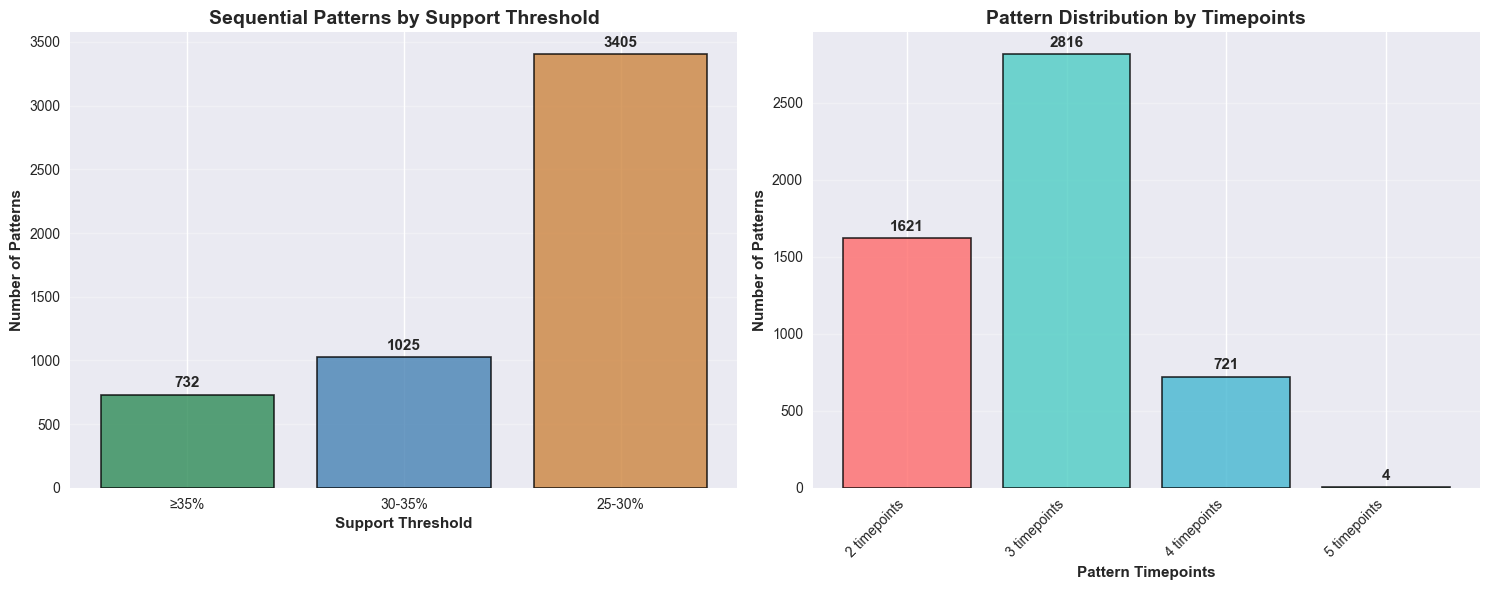

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

colors1 = ['#2E8B57', '#4682B4', '#CD853F']
bars1 = ax1.bar(range(len(support_data)), list(support_data.values()), 
                color=colors1, alpha=0.8, edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Support Threshold', fontweight='bold')
ax1.set_ylabel('Number of Patterns', fontweight='bold')
ax1.set_title('Sequential Patterns by Support Threshold', fontweight='bold', fontsize=14)
ax1.set_xticks(range(len(support_data)))
ax1.set_xticklabels(list(support_data.keys()), fontsize=10)
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(list(support_data.values()))*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

colors2 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars2 = ax2.bar(range(len(complexity_data)), list(complexity_data.values()), 
                color=colors2, alpha=0.8, edgecolor='black', linewidth=1.2)

ax2.set_xlabel('Pattern Timepoints', fontweight='bold')
ax2.set_ylabel('Number of Patterns', fontweight='bold')
ax2.set_title('Pattern Distribution by Timepoints', fontweight='bold', fontsize=14)
ax2.set_xticks(range(len(complexity_data)))
ax2.set_xticklabels(list(complexity_data.keys()), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(list(complexity_data.values()))*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

This visualization presents the outcomes of applying the Fournier08 closed sequential pattern mining algorithm to the temporal dataset, demonstrates the distribution of discovered patterns across three support threshold categories: ≥35% Support (732 patterns) - that likely capture core disease mechanisms that are universally present in ALS progression.; 30-35% Support (1,025 patterns) - with potentially capturing specific progression patterns or intermediate disease stages and, finally 25-30% Support (3,405 patterns): that may capture rare but eventually clinically meaningful progression variants. As such, in the significant patient-to-patient variability in progression patterns, our choice of support may depend on the depth that we want to achieve in terms of heterogeneity - while a higher support may give us an overview of a population, a lower support can leads to consider more personalized evolutions of ALS. Our experiment with 20% of support demonstrates this - we have even more patterns, but specially we find an increase in the 5 time-points patterns, which can lead us to view a more complex clinical evolution of a particular patient. 
Then we have the temporal distribution of the discovered patterns: 2 timepoints (1,621 patterns) - that represent simple temporal transitions between two consecutive visits; 3 timepoints (2,816 patterns) - shows the highest count, suggesting a balance in temporal analysis and patient evolution; 4 timepoints (721 patterns) -  rarer but potentially more informative about long-term disease trajectories and finally, the 5 timepoints (4 patterns) - with very few patients sharing identical progression sequences across all five maximum timepoints.


The exponential increase in patterns as support decreases, combined with the rapid decrease in patterns as temporal complexity increases, confirms the high heterogeneity of ALS progression. This supports personalized medicine approaches, although short-term changes (2-3 timepoints) are common and well-captured and are valuable to understand the full context of the disease. 
Ultimately, this showed us that temporal pattern mining can extract meaningful insights about ALS, and that we should not only consider the static nature of the disease when considering treatment solutions.

#### Feature Visualization by Timepoints

Analyzing 1621 patterns with 2 timepoints
Analyzing 2816 patterns with 3 timepoints
Analyzing 721 patterns with 4 timepoints
Analyzing 4 patterns with 5 timepoints


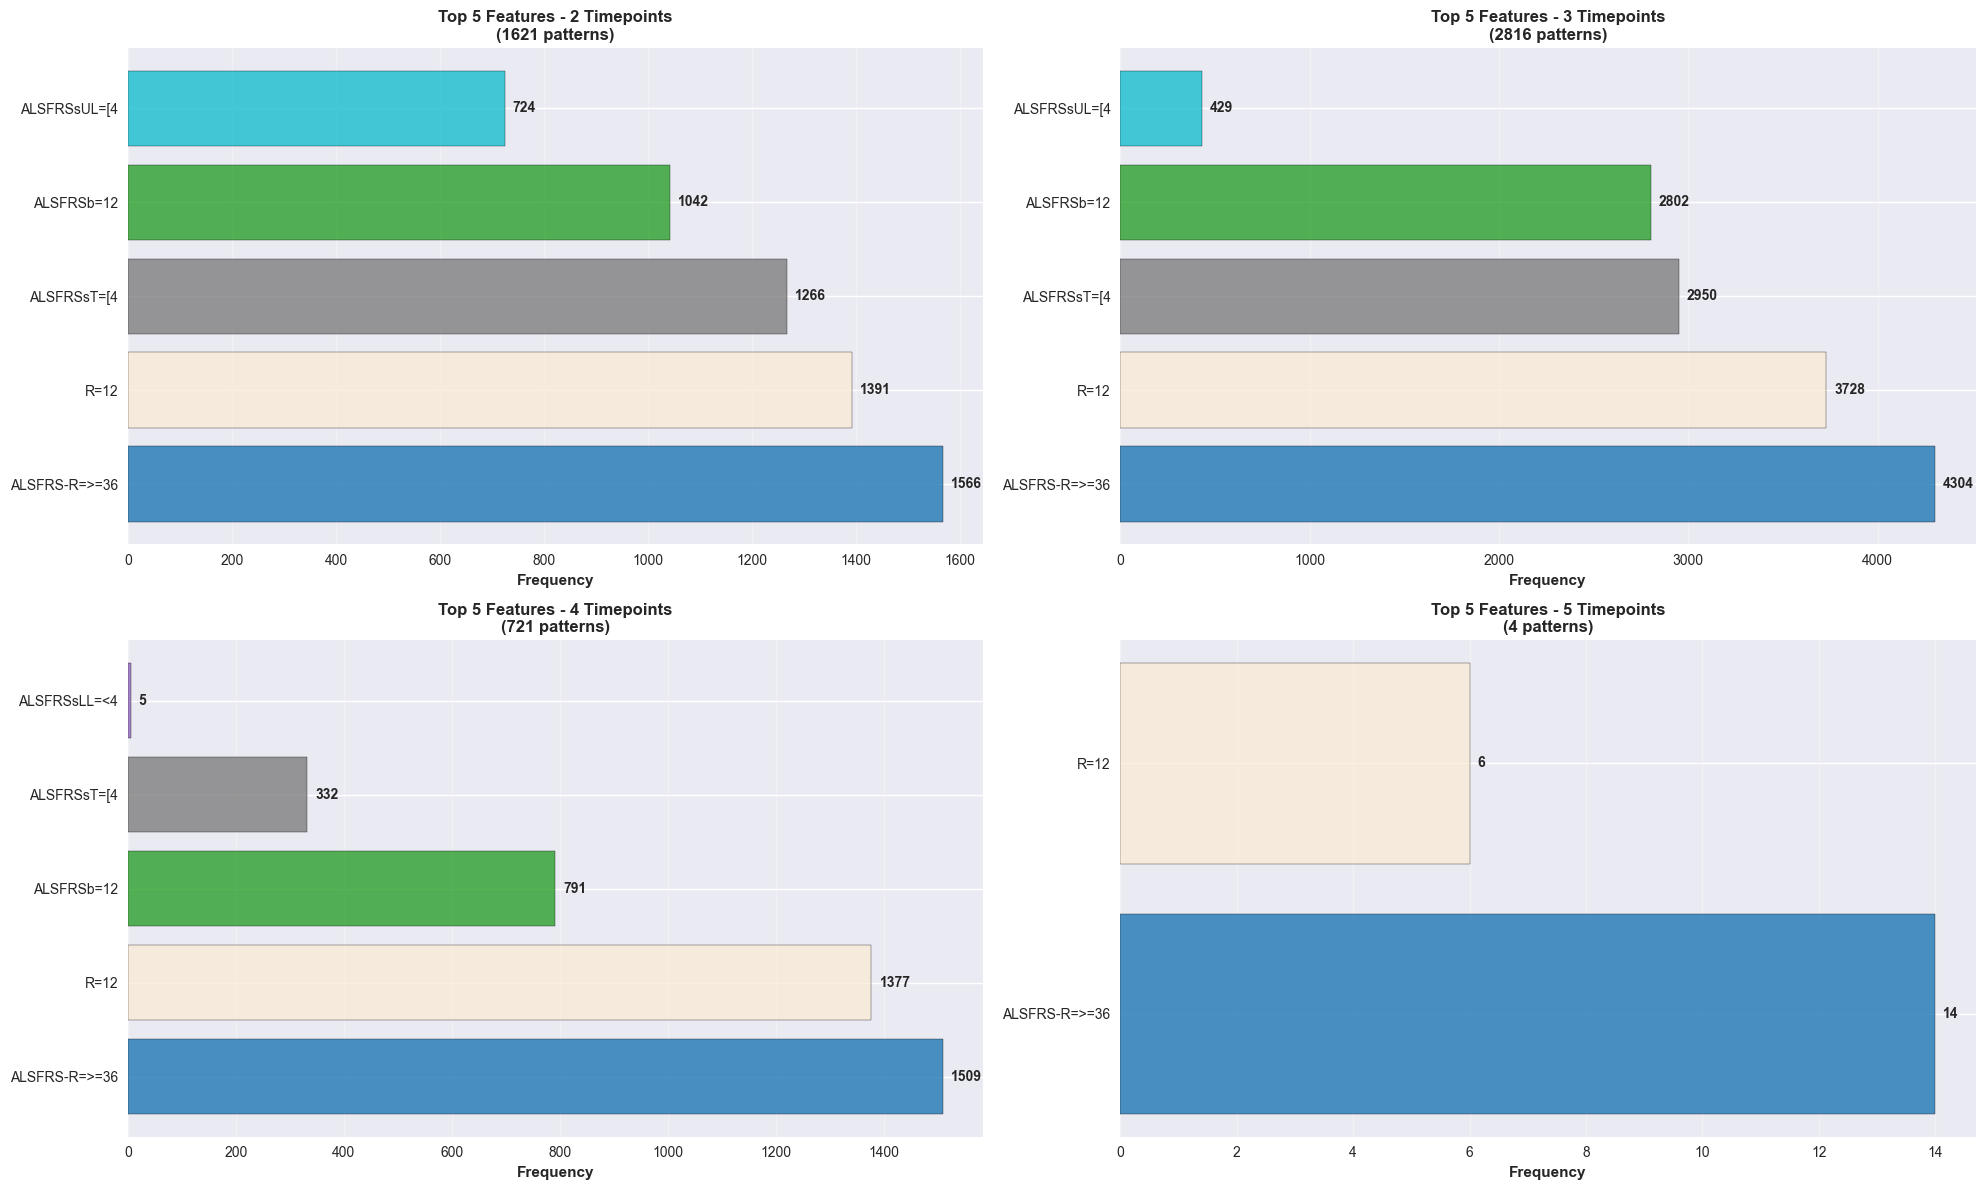

In [ ]:
top_features_by_timepoints = create_feature_visualization_by_timepoints(df_matches)

Naturally, what lacked in our analysis was a breakdown of the most frequently occurring features in sequential patterns, organized by the range of timepoints. 
2 Timepoints (1,621 patterns): ALSFRS-R>=36 (1,566 occurrences) - dominates with the highest frequency, followed by R=12 (1,391 occurrences), ALSFRSsT=[4 (1,266 occurrences), ALSFRSb=12 (1,042 occurrences) and ALSFRSsUL=[4 (724 occurrences) The dominance of ALSFRS-R>=36 (indicating relatively preserved overall function) and R=12 (with the maximum respiratory score) suggests that many 2-timepoint patterns capture patients in early disease stages or those with slower progression. The presence of ALSFRSsT=[4 and ALSFRSsUL=[4 indicates that limb function deterioration patterns are commonly captured even in simple temporal sequences.


3 Timepoints (2,816 patterns): Follows the exact same structure of the 2 time point. However, the substantial increase in all feature frequencies indicate that these core features remain important as pattern complexity increases.


4 Timepoints (721 patterns): ALSFRS-R>=36 (1,509 occurrences); R=12 (1,377 occurrences); ALSFRSb=12 (791 occurrences); ALSFRSsT=[4 (332 occurrences) and ALSFRSsUL=<4 (5 occurrences). The emergence of ALSFRSsUL=<4 (severe upper limb dysfunction) in longer patterns suggests that severe functional decline becomes more apparent in extended temporal sequences, which makes sense considering the evolution of the disease.

5 Timepoints (4 patterns), ALSFRS-R>=36 (14 occurrences) and R=12 (6 occurrences) - this frequency at 5 timepoints confirms that very few patients share identical progression sequences over extended periods at this support, highlighting the high individual variability in long-term ALS progression. If we were to capture more particular evolutions of ALS, our support would need to be lower.

## 20% Minimum Support Sequential Patterns

In [667]:
os.system("java -jar spmf.jar run Fournier08-Closed+time sequences.txt output_20.txt 20% 0 5 0 5")

0

In [668]:
filter_outputs_by_len(input_file='output_20.txt', output_file='filtered_output_20.txt')

Filtered file written to filtered_output_20.txt


In [669]:
df_matches = extract_pattern_matches('filtered_output_20.txt', sequences)

In [670]:
df_matches.head(3)

pattern  \
0                    <0> R=12 -1 <1> R=12 -1   
1  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1   
2           <0> ALSFRS-R=>=36 -1 <1> R=12 -1   

                               decoded_pattern  support  \
0                    (0, R = 12 ) (1, R = 12 )      524   
1  (0, ALSFRS-R = >=36 ) (1, ALSFRS-R = >=36 )      511   
2           (0, ALSFRS-R = >=36 ) (1, R = 12 )      502   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     REF  \
0      [2, 8, 9, 10, 17, 18, 20, 21, 24, 30, 34, 35, 36, 39, 40, 42, 43, 45, 46, 49, 50, 54, 55, 56, 64, 66, 67, 72, 74, 78, 79, 82, 85, 88, 91, 93, 94, 100, 103, 104, 105, 111, 113, 115, 119, 122, 125, 126, 133, 136, 137, 141, 144, 145, 151, 153, 156, 161, 162, 164, 165, 166, 167, 169, 171, 173, 174, 176, 177, 178, 179, 180, 185, 196, 197, 200, 201, 202, 205, 207, 210, 211, 212, 213, 214, 215, 216, 219, 220, 227, 236, 238, 241, 242, 247, 250, 253, 256, 259, 261, ...]   
1      [2, 8, 9, 10, 17, 21, 24, 26, 30, 34, 35, 39, 40, 42, 45, 46, 49, 50, 54, 55, 56, 60, 61, 63, 64, 66, 72, 74, 78, 79, 82, 85, 88, 91, 93, 94, 99, 100, 103, 104, 113, 115, 119, 122, 126, 134, 136, 137, 141, 151, 155, 156, 160, 161, 162, 164, 166, 167, 169, 171, 173, 174, 176, 177, 179, 185, 196, 197, 200, 202, 203, 205, 207, 208, 210, 211, 212, 213, 214, 215, 217, 220, 227, 236, 238, 241, 242, 243, 244, 247, 250, 253, 256, 259, 261, 262, 263, 265, 267, 269, ...]   
2  [2, 8, 9, 10, 17, 21, 24, 30, 34, 35, 39, 40, 42, 45, 46, 49, 50, 54, 55, 56, 64, 66, 67, 72, 74, 78, 79, 82, 85, 88, 91, 93, 94, 100, 103, 104, 105, 113, 115, 119, 122, 126, 134, 136, 137, 141, 144, 145, 151, 153, 156, 161, 162, 164, 165, 166, 167, 169, 171, 173, 174, 176, 177, 178, 179, 180, 185, 196, 197, 200, 202, 205, 207, 210, 211, 212, 213, 214, 215, 220, 227, 236, 238, 241, 242, 247, 250, 253, 256, 259, 261, 262, 263, 265, 267, 269, 271, 273, 277, 278, ...]   

   support_pct  
0        75.83  
1        73.95  
2        72.65

In [ ]:
df_exploded = df_matches[['pattern', 'REF']].explode('REF')

binary_df = pd.crosstab(df_exploded['REF'], df_exploded['pattern'])

binary_df = binary_df.astype(int)

binary_df = binary_df.reset_index()

print(f"Binary matrix shape: {binary_df.shape}")
print(f"Number of patients: {len(binary_df)}")
print(f"Number of patterns: {len(binary_df.columns) - 1}")

binary_df.head()

Binary matrix shape: (691, 15698)
Number of patients: 691
Number of patterns: 15697


pattern  REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0          2                                          1   
1          8                                          1   
2          9                                          1   
3         10                                          1   
4         14                                          0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                                     1   
1                                                                     0   
2                                                                     1   
3                                                                     1   
4                                                                     0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                          1   
1                                                                                          0   
2                                                                                          0   
3                                                                                          0   
4                                                                                          0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                               0   
1                                                                                                               0   
2                                                                                                               0   
3                                                                                                               0   
4                                                                                                               0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSb=12 -1  \
0                                                                                                            0   
1                                                                                                            0   
2                                                                                                            0   
3                                                                                                            0   
4                                                                                                            0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSsT=[4,8[ -1  \
0                                                                                                                0   
1                                                                                                                0   
2                                                                                                                0   
3                                                                                                                0   
4                                                                                                                0   

pattern  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                      0   
1                                                                                                      0   
2                                                                                                      0   
3                                                                                       

In [672]:
binary_df = binary_df.merge(static_df, on='REF', how='inner')

In [673]:

binary_df = pd.get_dummies(binary_df, columns=['Gender', 'Revised El Escorial Criteria', 'Onset', 'MND familiar history', 'C9orf72'], dtype=int)

In [674]:
binary_df.head(3)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   
2    9                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   
2                                                               1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   
2                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   
2                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSb=12 -1  \
0                                                                                                      0   
1                                                                                                      0   
2                                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSsT=[4,8[ -1  \
0                                                                                                          0   
1                                                                                                          0   
2                                                                                                          0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   
2                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 ALSFRS-R=>=36 -1  \
0                                                                                                              0   
1                                                                                                              0   
2                                                                                                              0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   
2                                                                                 1   

   ...  Onset_Limbs  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...            1                  0            0              0   
1  ...            1                  0            0              0   
2  ...            1                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   
2                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  
0                   

In [675]:
binary_df = binary_df.merge(evolution_df, on='REF', how='left')

In [676]:
binary_df.head(3)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   
2    9                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   
2                                                               1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   
2                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   
2                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSb=12 -1  \
0                                                                                                      0   
1                                                                                                      0   
2                                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSsT=[4,8[ -1  \
0                                                                                                          0   
1                                                                                                          0   
2                                                                                                          0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   
2                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 ALSFRS-R=>=36 -1  \
0                                                                                                              0   
1                                                                                                              0   
2                                                                                                              0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   
2                                                                                 1   

   ...  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...                  0            0              0   
1  ...                  0            0              0   
2  ...                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   
2                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  \
0                             0           0            0               

In [677]:
binary_df['Evolution'] = (binary_df['Evolution'] == 'Y').astype(int)

In [678]:
binary_df.head(3)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   
2    9                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   
2                                                               1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   
2                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   
2                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSb=12 -1  \
0                                                                                                      0   
1                                                                                                      0   
2                                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSsT=[4,8[ -1  \
0                                                                                                          0   
1                                                                                                          0   
2                                                                                                          0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   
2                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 ALSFRS-R=>=36 -1  \
0                                                                                                              0   
1                                                                                                              0   
2                                                                                                              0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   
2                                                                                 1   

   ...  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...                  0            0              0   
1  ...                  0            0              0   
2  ...                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   
2                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  \
0                             0           0            0               

In [679]:
evolution_counts = binary_df['Evolution'].value_counts()
print(f"\nEvolution counts:\n{evolution_counts}")


Evolution counts:
Evolution
0    321
1    307
Name: count, dtype: int64


In [ ]:
X = binary_df.drop(columns='Evolution')
y = binary_df['Evolution']

In [681]:
X.head(2)

REF  <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1  \
0    2                                          1   
1    8                                          1   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1  \
0                                                               1   
1                                                               0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1  \
0                                                                                    1   
1                                                                                    0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRS-R=>=36 -1  \
0                                                                                                         0   
1                                                                                                         0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSb=12 -1  \
0                                                                                                      0   
1                                                                                                      0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> ALSFRSsT=[4,8[ -1  \
0                                                                                                          0   
1                                                                                                          0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 -1  \
0                                                                                                0   
1                                                                                                0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRS-R=>=36 -1 <4> R=12 ALSFRS-R=>=36 -1  \
0                                                                                                              0   
1                                                                                                              0   

   <0> ALSFRS-R=>=36 -1 <1> ALSFRS-R=>=36 -1 <2> ALSFRS-R=>=36 -1 <3> ALSFRSb=12 -1  \
0                                                                                 1   
1                                                                                 0   

   ...  Onset_Limbs  Onset_Respiratory  Onset_axial  Onset_diffuse  \
0  ...            1                  0            0              0   
1  ...            1                  0            0              0   

   MND familiar history_No  MND familiar history_Yes  \
0                        1                         0   
1                        1                         0   

   MND familiar history_unknown  C9orf72_No  C9orf72_Yes  C9orf72_unknown  
0                             0           0            0                1  
1                             0           0            0                1  

[2 rows x 15720 columns]

In [682]:
print(f"Number of refs: {len(binary_df)}")

Number of refs: 628


In [ ]:
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print(f"5‐fold CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

5‐fold CV accuracy: 0.572 ± 0.045


Looking at the corrected Random Forest classification results, the 25% minimum support achieved 0.557 ± 0.058 accuracy while the 20% minimum support achieved 0.572 ± 0.045 accuracy, representing a minimal improvement of 1.5 percentage points. Despite the 20% support configuration discovering approximately three times more patterns (~15,697 vs ~5,162), this substantial increase in feature richness only translated to a marginal performance gain. This leads us to believe that while the additional rare patterns captured at lower support thresholds are important, the core disease progression signatures captured at 25% support already contain most of the information.

### Analysis and Discussion

Analyzing 2955 patterns with 2 timepoints
Analyzing 7793 patterns with 3 timepoints
Analyzing 4754 patterns with 4 timepoints
Analyzing 195 patterns with 5 timepoints


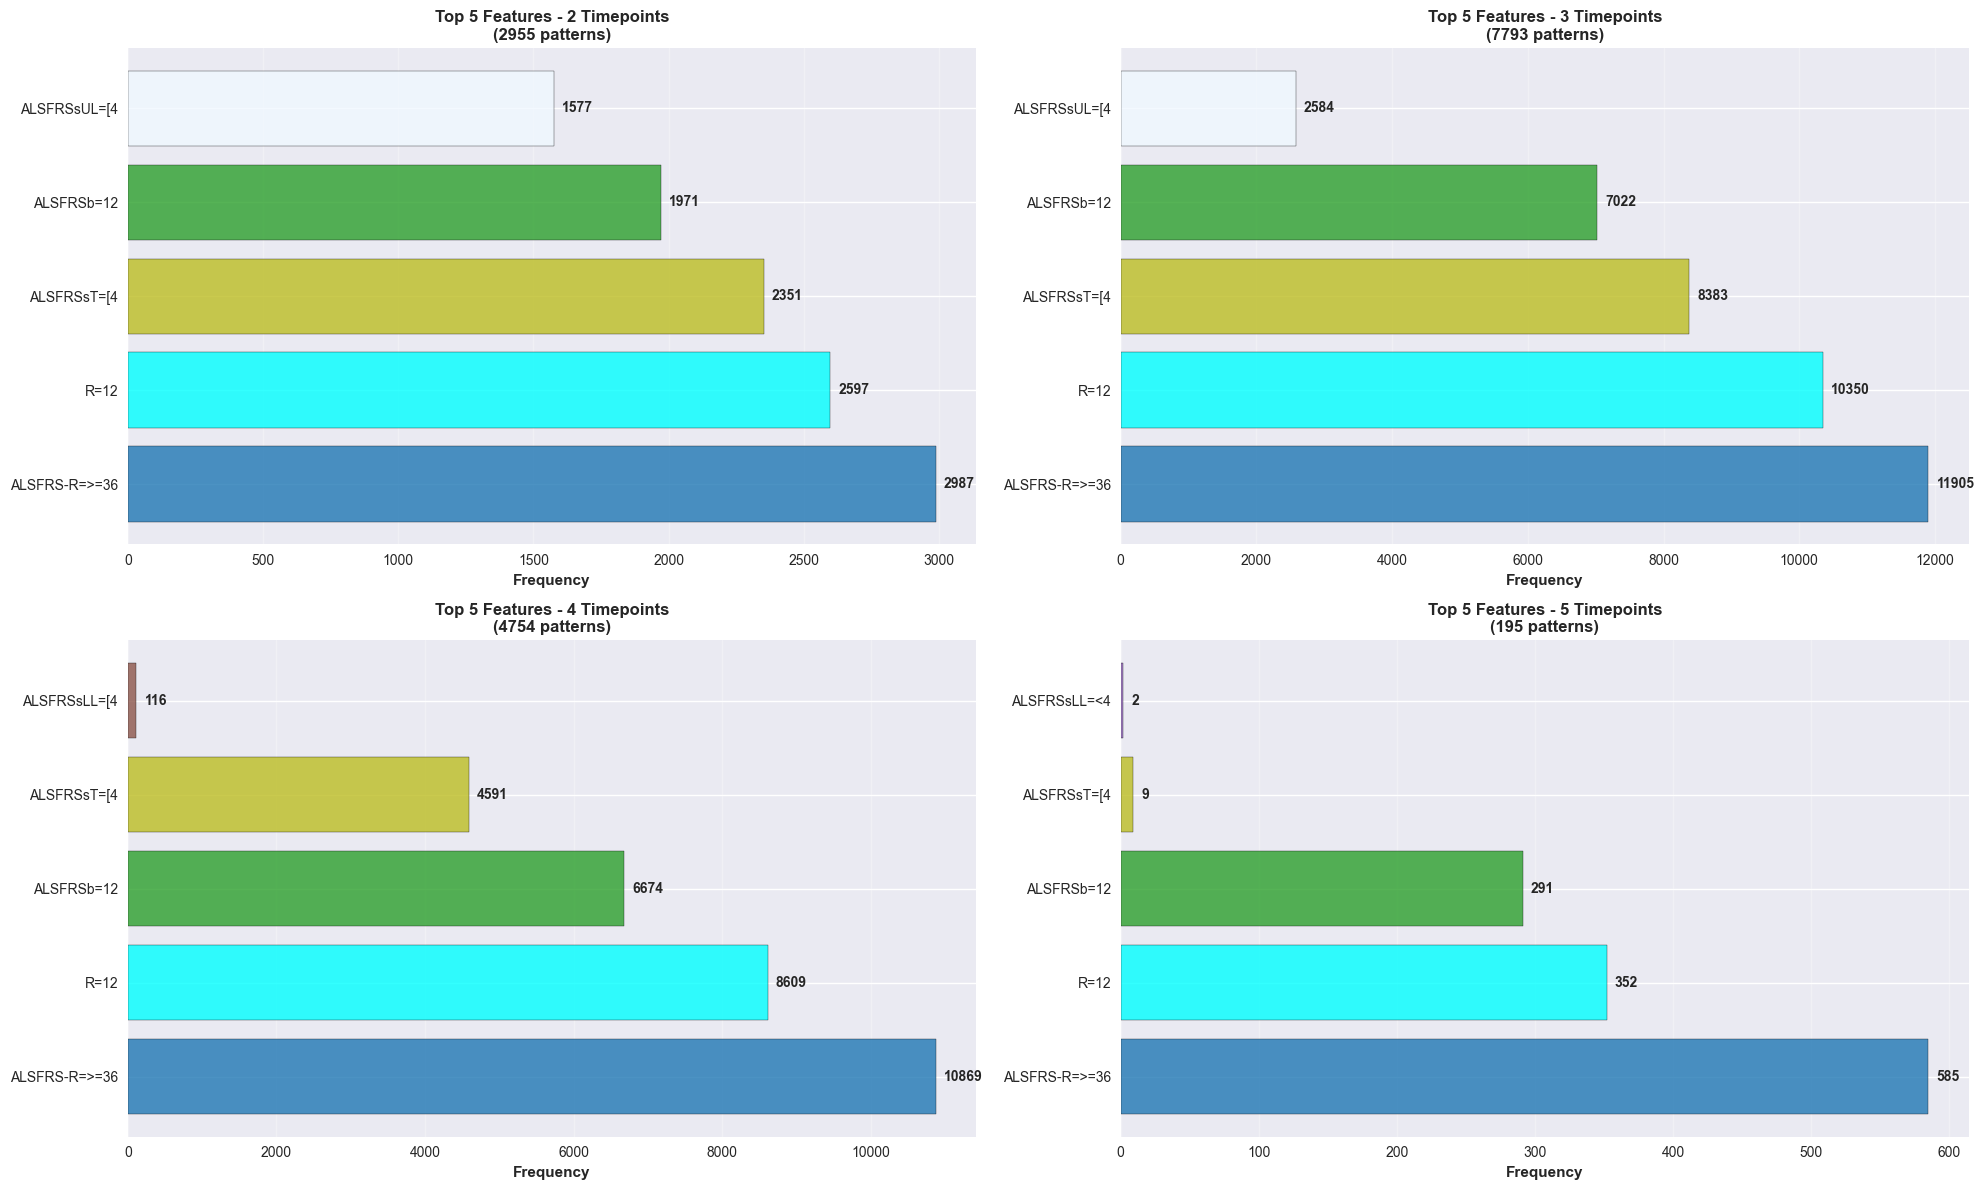

In [686]:
top_features_by_timepoints = create_feature_visualization_by_timepoints(df_matches)

Again, and to make a final comparison, the visualization shows the top 5 features by time point complexity for the 20% minimum support configuration, revealing patterns very similar to the 25% support results with consistent feature rankings across all temporal complexities. The most notable difference occurs in the 5-time point category, where the 20% support dramatically improves pattern discovery with 195 patterns compared to only 4 patterns at 25% support. This substantial improvement in capturing extended temporal sequences is on par with our argument that the 20% support threshold is fundamental for discovering meaningful long-term disease progression patterns that were missed at the higher 25% threshold. 
In conclusion, we were able to verify that temporal patterns are truly effective in establishing the progression of ALS, and we can see how certain features can impact different patients, while also seeing similarities in their clinical pictures. Similarly, our experiences with minimum supports lead us to believe that these will have to be fundamentally adapted to the research objective: higher supports to capture general trends and basic progressions, and lower supports to obtain more ALS trajectories that may prove very useful for detecting and acting on specific scenarios.